[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mobasserulHaque/Explainable-Techniques-II/blob/main/Assignment4_Explainable_Techniques_2.ipynb)





### Assignment 4 : Explainable Techniques II

**Mobasserul Haque**

## Attribution (Use of AI Citation)  

>The README was generated with assistance from an AI system (GPT-5 Thinking) and subsequently reviewed/edited by the author, who is responsible for the final content.

Remaining parts of assignment LLMs have not been used



Our Goal is to Produce PDP, ICE, and ALE plots on a tabular model; examine feature correlations and discuss how correlation affects PDP vs. ALE.

### Dataset

- I have used the PRSA (Beijing) dataset contains hourly records of air quality and meteorological variables collected between 2010 and 2014.

- In this project, the goal is to predict PM2.5 concentration (µg/m³) using features such as temperature, pressure, dew point, wind speed, and temporal indicators like hour and month.

- This dataset is ideal for explainable modeling because it exhibits real-world nonlinear patterns and moderate correlations among features—conditions that make it especially useful for comparing how Partial Dependence Plots (PDP) and Accumulated Local Effects (ALE) respond to correlated predictors.


In [3]:
# --- Install required libraries (ALE from PyALE)
!pip install -q PyALE


import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

# Stats & correlation
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ALE (using PyALE)
from PyALE import ale

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility & style
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style="ticks")
plt.rcParams["figure.dpi"] = 120

def compute_vif(df_features: pd.DataFrame) -> pd.DataFrame:
    """Compute Variance Inflation Factors (VIF) for each numeric feature."""
    X = sm.add_constant(df_features)
    vifs = []
    for i in range(1, X.shape[1]):  # skip intercept
        vifs.append(variance_inflation_factor(X.values, i))
    return pd.DataFrame({"feature": df_features.columns, "VIF": vifs}).sort_values("VIF", ascending=False)



### 2. Data Loading, Cleaning, and Feature Engineering

We import the PRSA (Beijing) hourly dataset, parse datetimes, and create meteorological + temporal features (hour, month, day-of-week, season, weekend). We keep the target as PM2.5 (µg/m³) and handle missing values. Categorical wind direction is retained for modeling via one-hot encoding later.

In [4]:
# URL for PRSA Beijing PM2.5 dataset
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"

# Loading the dataset
try:
    df_raw = pd.read_csv(URL, na_values=["NA", "NaN", "null"])
except Exception as e:
    raise RuntimeError(f"Failed to load dataset from {URL}. Error: {e}")

# cleanup
# Expected columns: ['No','year','month','day','hour','pm2.5','DEWP','TEMP','PRES','cbwd','Iws','Is','Ir']
expected_cols = {"No","year","month","day","hour","pm2.5","DEWP","TEMP","PRES","cbwd","Iws","Is","Ir"}
missing_cols = expected_cols - set(df_raw.columns)
if missing_cols:
    print("Warning: Missing expected columns:", missing_cols)


df = df_raw.copy()
df["datetime"] = pd.to_datetime(df[["year","month","day","hour"]], errors="coerce")

# Target
target_col = "pm2.5"

# Temporal features
df["hour"] = df["hour"].astype(int)
df["month"] = df["month"].astype(int)
df["dow"] = df["datetime"].dt.dayofweek  # 0=Mon, 6=Sun
df["is_weekend"] = (df["dow"] >= 5).astype(int)

# Season
def season_of_month(m):
    if m in (12,1,2):
        return "winter"
    if m in (3,4,5):
        return "spring"
    if m in (6,7,8):
        return "summer"
    return "autumn"
df["season"] = df["month"].apply(season_of_month)

# Meteorological features (already numeric)
# TEMP (°C), DEWP (°C), PRES (hPa), Iws (cumulated wind speed), Is/Ir (hours of snow/rain in last hour)
num_cols = ["TEMP", "DEWP", "PRES", "Iws", "Is", "Ir", "hour", "month", "dow", "is_weekend"]

# Keep categorical wind direction for one-hot encoding
cat_cols = ["cbwd", "season"]


before = len(df)
df = df.dropna(subset=[target_col, "datetime"]).reset_index(drop=True)
after = len(df)

features_all = num_cols + cat_cols
df_model = df[features_all + [target_col]].dropna().reset_index(drop=True)

print("Raw shape:", df_raw.shape)
print("After dropping NA target/datetime:", (after, df_raw.shape[1]))
print("Modeling frame shape (after feature NA drop):", df_model.shape)

print("\nColumns:", df_model.columns.tolist())
print("\nMissing values (remaining):")
print(df_model.isna().sum().sort_values(ascending=False).head(10))

print("\nCategorical levels:")
for c in cat_cols:
    print(f"  {c}: {df_model[c].nunique()} levels -> {sorted(df_model[c].unique().tolist())[:10]}")

df_model.head(5)


Raw shape: (43824, 13)
After dropping NA target/datetime: (41757, 13)
Modeling frame shape (after feature NA drop): (41757, 13)

Columns: ['TEMP', 'DEWP', 'PRES', 'Iws', 'Is', 'Ir', 'hour', 'month', 'dow', 'is_weekend', 'cbwd', 'season', 'pm2.5']

Missing values (remaining):
TEMP          0
DEWP          0
PRES          0
Iws           0
Is            0
Ir            0
hour          0
month         0
dow           0
is_weekend    0
dtype: int64

Categorical levels:
  cbwd: 4 levels -> ['NE', 'NW', 'SE', 'cv']
  season: 4 levels -> ['autumn', 'spring', 'summer', 'winter']


,TEMP,DEWP,PRES,Iws,Is,Ir,hour,month,dow,is_weekend,cbwd,season,pm2.5
0,-4.0,-16,1020.0,1.79,0,0,0,1,5,1,SE,winter,129.0
1,-4.0,-15,1020.0,2.68,0,0,1,1,5,1,SE,winter,148.0
2,-5.0,-11,1021.0,3.57,0,0,2,1,5,1,SE,winter,159.0
3,-5.0,-7,1022.0,5.36,1,0,3,1,5,1,SE,winter,181.0
4,-5.0,-7,1022.0,6.25,2,0,4,1,5,1,SE,winter,138.0


We loaded the **PRSA (Beijing) Hourly Air Quality dataset** and constructed a clean modeling frame of **41,757 rows × 13 columns** after removing records with missing `pm2.5` values or invalid timestamps (from **43,824 raw rows**).

- **Target variable:** `pm2.5` (µg/m³) — fine particulate matter concentration  
- **Predictors:**
  - **Meteorological variables:** `TEMP`, `DEWP`, `PRES`, `Iws`, `Is`, `Ir`
  - **Temporal features:** `hour`, `month`, `dow` (day of week), `is_weekend`
  - **Categorical features:**  
    - `cbwd` — wind direction (`NE`, `NW`, `SE`, `cv`)  
    - `season` — (`spring`, `summer`, `autumn`, `winter`)

**Missing values:** None remain after cleaning, so no imputation is required.

This feature design captures both **meteorological factors** and **temporal dynamics** (time-of-day, seasonality), enabling non-linear effect analysis using methods such as **Partial Dependence Plots (PDP)**, **Individual Conditional Expectation (ICE)**, and **Accumulated Local Effects (ALE)**.


### 3. Train/Test Split, Encoding, Model Training, and Baseline Metrics

We’ll one-hot encode categorical features, keep numeric features as-is, train a RandomForestRegressor, and report R²/RMSE. We also surface feature importances (mapped to transformed feature names) to choose targets for PDP/ICE/ALE.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Define features/target
target_col = "pm2.5"

num_cols = ["TEMP", "DEWP", "PRES", "Iws", "Is", "Ir", "hour", "month", "dow", "is_weekend"]
cat_cols = ["cbwd", "season"]

X = df_model[num_cols + cat_cols].copy()
y = df_model[target_col].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

# one-hot for categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

rf = RandomForestRegressor(
    n_estimators=600,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("rf", rf)
])

pipe.fit(X_train, y_train)

# --- Evaluate
y_pred = pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test R²:  {r2:.3f}")
print(f"Test RMSE: {rmse:.3f} µg/m³")


# Extract transformed feature names & importances
# The underlying rf is the final step in the pipeline
rf_model = pipe.named_steps["rf"]
feat_names = pipe.named_steps["prep"].get_feature_names_out()

importances = pd.Series(rf_model.feature_importances_, index=feat_names).sort_values(ascending=False)

print("\nTop 15 features by RF impurity importance:")
display(importances.head(15))

# objects for later cells (PDP/ICE/ALE)
preprocessor = pipe.named_steps["prep"]
model = pipe.named_steps["rf"]
X_train_trans = preprocessor.transform(X_train)  # not required now, but sometimes handy
X_test_trans = preprocessor.transform(X_test)
feat_names = preprocessor.get_feature_names_out()

pd.DataFrame({"y_test": y_test[:5].values, "y_pred": y_pred[:5]}).head()


Test R²:  0.690
Test RMSE: 51.943 µg/m³

Top 15 features by RF impurity importance:


,0
DEWP,0.260769
Iws,0.120224
season_winter,0.115611
PRES,0.109475
TEMP,0.094577
month,0.087845
hour,0.074562
dow,0.070449
cbwd_SE,0.025265
is_weekend,0.007466


,y_test,y_pred
0,215.0,155.202066
1,6.0,14.293429
2,280.0,237.641276
3,57.0,54.799247
4,50.0,65.391675


The Random Forest baseline achieves R² = 0.690 and RMSE = 51.94 µg/m³ on the test set. This is reasonable for hourly PM2.5 with noisy meteorology and time signals.

The top drivers by impurity importance are DEWP (dew point), Iws (cumulative wind speed), season_winter, PRES (pressure), and TEMP, followed by time signals (month, hour, day-of-week) and wind direction dummies.

Taken together, these suggest a physically plausible story: moisture/temperature/pressure set the dispersion/formation conditions, while wind and seasonality modulate accumulation and transport; time-of-day captures human activity cycles.

We’ll use these leading features for PDP/ICE/ALE and check how correlation among meteorological variables affects PDP vs. ALE interpretations.

### 4. Correlation analysis (Pearson, Spearman) & multicollinearity (VIF)

We’ll quantify correlation structure among numeric predictors and compute VIFs. This will help us judge when PDP might go off-manifold and when ALE is more reliable.

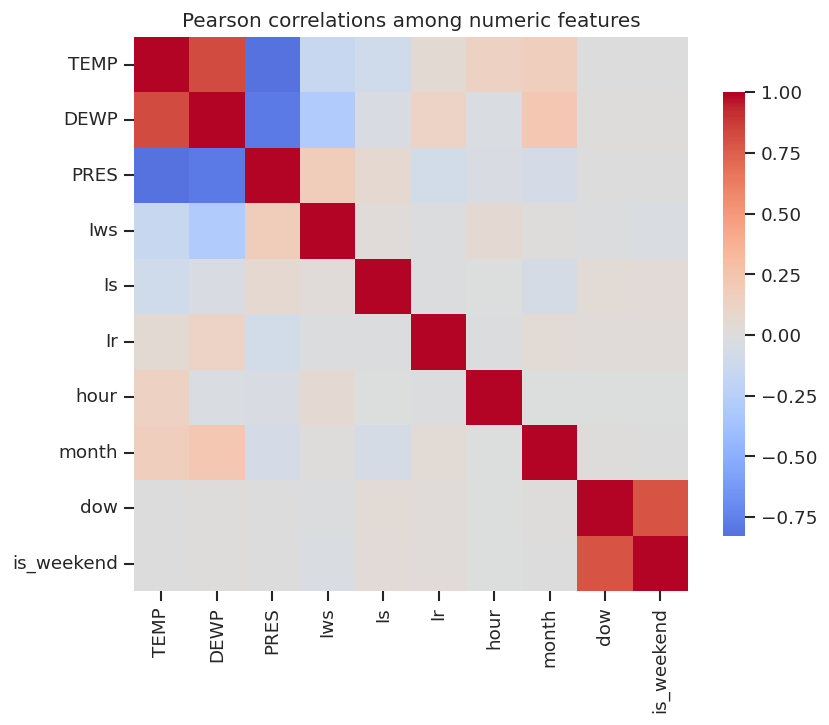

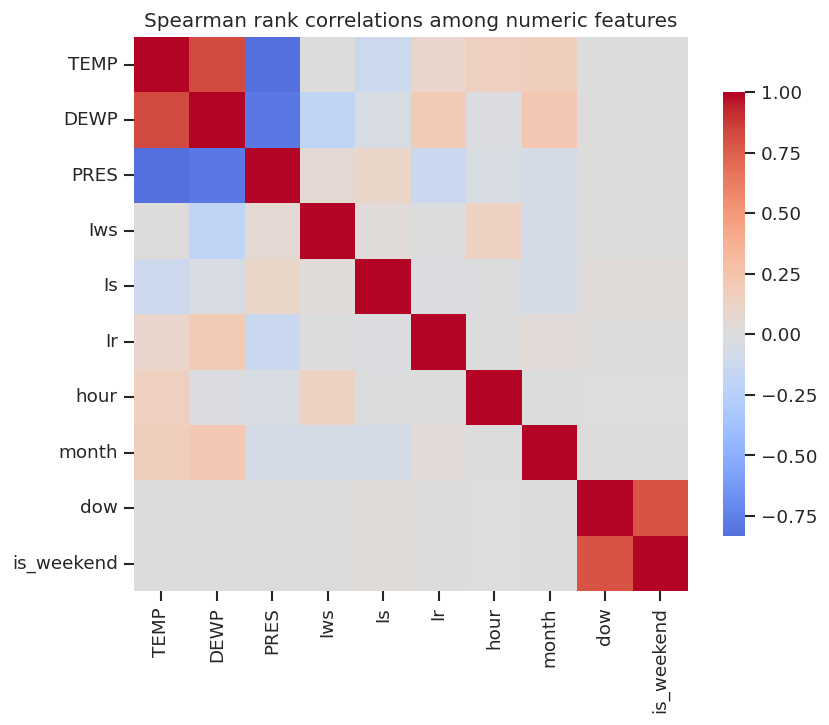

Top correlated numeric pairs (Pearson):


,feat_1,feat_2,abs_corr
0,TEMP,PRES,0.826903
1,PRES,TEMP,0.826903
2,DEWP,TEMP,0.823821
3,TEMP,DEWP,0.823821
4,is_weekend,dow,0.789155
5,dow,is_weekend,0.789155
6,DEWP,PRES,0.777722
7,PRES,DEWP,0.777722
8,DEWP,Iws,0.293106
9,Iws,DEWP,0.293106



Variance Inflation Factors (VIF):


,feature,VIF
0,TEMP,4.889565
1,DEWP,4.272012
2,PRES,3.652096
8,dow,2.653317
9,is_weekend,2.652849
3,Iws,1.142263
7,month,1.119616
6,hour,1.104171
5,Ir,1.030221
4,Is,1.024013


In [7]:
# Numeric columns only (including binary is_weekend)
num_cols = ["TEMP", "DEWP", "PRES", "Iws", "Is", "Ir", "hour", "month", "dow", "is_weekend"]

# Correlation matrices
corr_pearson = df_model[num_cols].corr(method="pearson")
corr_spearman = df_model[num_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(7.5, 6))
sns.heatmap(corr_pearson, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Pearson correlations among numeric features")
plt.show()

fig, ax = plt.subplots(figsize=(7.5, 6))
sns.heatmap(corr_spearman, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Spearman rank correlations among numeric features")
plt.show()

# strongest absolute Pearson correlations
corr_abs = corr_pearson.abs().where(~np.eye(len(corr_pearson), dtype=bool))
top_pairs = (
    corr_abs.stack()
    .sort_values(ascending=False)
    .dropna()
    .reset_index()
)
top_pairs.columns = ["feat_1", "feat_2", "abs_corr"]
print("Top correlated numeric pairs (Pearson):")
display(top_pairs.head(10))

# VIF for multicollinearity
vif_df = compute_vif(df_model[num_cols])
print("\nVariance Inflation Factors (VIF):")
display(vif_df)

corr_pearson_vals = corr_pearson.copy()
vif_table = vif_df.copy()
